In [1]:
!nvidia-smi

Thu Nov 13 19:59:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   26C    P8                1W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

import sys
#sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
#os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", False)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_17181/4097952282.py:16: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
import diffhydro as dh


eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[256,256,256]

In [4]:
U = dh.prob_gen.make_gaussian_blob_rho(eq,eq.mesh_shape,sigma=40)

In [5]:
import jax.numpy as jnp
#U = jnp.roll(U,20,axis=2)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


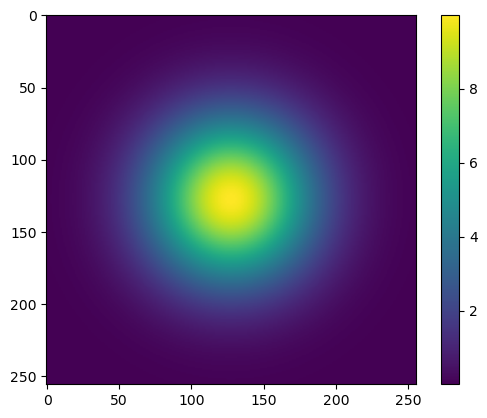

In [6]:
%pylab inline
imshow(U[0][128])
colorbar()
show()

In [7]:
eq.cfl = 0.4
ss = dh.signal_speed_Rusanov

#TF = dh.turbulence.TurbulentForce(eq)

grav_fft = dh.physics.gravity.FFTSelfGravityForce(eq, G=6E-4, subtract_mean=True)  
grav_mg_acc = dh.physics.gravity.MGSelfGravityForce(eq, G=6E-4, l=4, dx=1.0, subtract_mean=True,
                          v1=4, v2=4, mu=2, iter_cycle=3, mg_tol=1e-8,
                          checkpoint_mg=False)   # turn on if VJP memory is tight

grav_mg = dh.physics.gravity.MGSelfGravityForce(eq, G=6E-4, l=4, dx=1.0, subtract_mean=True,
                          v1=4, v2=4, mu=2, iter_cycle=3, mg_tol=1e-8,
                          checkpoint_mg=False)   # turn on if VJP memory is tight

In [8]:
#lets first try no sharding...

In [ ]:
fft_force = grav_fft.force(0,U,{},0.01)
mg_force = grav_mg.force(0,U,{},0.01)

In [ ]:
imshow((fft_force-U)[-3][128])
colorbar()

In [ ]:
imshow((mg_force-U)[-3][128])
colorbar()
show()

In [ ]:
#residual... present but <0.1%
imshow(((fft_force-U)[-3][128]-(mg_force-U)[-3][128])/(fft_force-U)[-3][128])
colorbar()
show()

imshow(((fft_force-U)[-2][128]-(mg_force-U)[-2][128])/(fft_force-U)[-2][128])
colorbar()
show()


imshow(((fft_force-U)[-4][:,128]-(mg_force-U)[-4][:,128])/(fft_force-U)[-4][:,128])
colorbar()
show()

In [ ]:
# 2 for iter =1
# sqrt(2) for iter =2

#sqrt(sqrt(2)) for iter = 3

plt.plot((fft_force-U)[-3][128][:,128])
plt.plot((mg_force-U)[-3][128][:,128],"r:")


In [ ]:
jax.debug.visualize_array_sharding(U[0][:,:,0])


In [ ]:
%timeit jax.block_until_ready(grav_mg.force(0,U,{},0.01))

In [ ]:
%timeit jax.block_until_ready(grav_fft.force(0,U,{},0.01))

In [ ]:
#lets see in shard form!

In [ ]:
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental import mesh_utils, multihost_utils

devices = mesh_utils.create_device_mesh((2,1,1))

mesh =  Mesh(devices, ('x', 'y', 'z'))
FIELD_XYZ = P(None, 'x', 'y', 'z')

sh_arr = NamedSharding(mesh, FIELD_XYZ)
fields0 = jax.device_put(U, sh_arr)


In [ ]:
jax.debug.visualize_array_sharding(fields0[0][:,:,0])


In [ ]:
%timeit jax.block_until_ready(grav_mg.force(0,fields0,{},0.01))

In [ ]:
%timeit jax.block_until_ready(grav_fft.force(0,fields0,{},0.01))

In [ ]:
def test_grad_fft(U):
    val = grav_fft.force(0,U,{},0.1)
    return jnp.sum(val[1][:,:,128:])

In [ ]:
vag = jax.value_and_grad(test_grad_fft)

In [ ]:
vag_fft = vag(fields0)

In [ ]:
%timeit jax.block_until_ready(vag(fields0))

In [ ]:
def test_grad_mg(U):
    val = grav_mg.force(0,U,{},0.1)
    return jnp.sum(val[1][:,:,128:])

In [ ]:
vag = jax.value_and_grad(test_grad_mg)

In [ ]:
vag_mg = vag(fields0)

In [ ]:
#they match! :/-< (hopefully still)

imshow(vag_fft[1][0][:,128])
colorbar()
show()

imshow(vag_mg[1][0][:,128])
colorbar()
show()

In [ ]:
%timeit jax.block_until_ready(vag(fields0))

In [ ]:
imshow(vag_fft[1][0][:,128],vmax=0.01,vmin=-0.01)
title("fft")
colorbar()
show()
imshow(vag_mg[1][0][:,128],vmax=0.01,vmin=-0.01)
title("mg")

colorbar()
show()

In [ ]:

solver = dh.LaxFriedrichs(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=True)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)

hydro = dh.hydro(n_super_step=800, fluxes=[cf],forces=[grav],
                 use_mol=True, 
                 integrator="RK2",
                 pmesh_shape=(2,2,1),snapshot_every=50) 


